In [1]:
import pandas as pd

# NFL Big Data Bowl Clustering Extra Point

## Import Data

In [2]:
plays = pd.read_csv("../../NFL Data/Data/plays.csv")
games = pd.read_csv("../../NFL Data/Data/games.csv")
players = pd.read_csv("../../NFL Data/Data/players.csv")
track_ep2018 = pd.read_csv("../../NFL Data/Data/tracking_ep18.csv")
track_ep2019 = pd.read_csv("../../NFL Data/Data/tracking_ep19.csv")
track_ep2020 = pd.read_csv("../../NFL Data/Data/tracking_ep20.csv")

In [3]:
tracking_fep = pd.read_csv("../../NFL Data/Data/tracking_fep.csv")

## Preprocessing Players Data

In [4]:
from Preprocessing_makers import preprocess_players

In [5]:
players_df = preprocess_players(players)

## Preprocessing Tracking Data

In [6]:
from Preprocessing_makers import preprocess_tracking, preprocess_football_track


In [7]:
ep_tracking_2018, ep_tracking_2019, ep_tracking_2020 = preprocess_tracking(track_ep2018, track_ep2019, track_ep2020, plays, 'Extra Point')


In [8]:
ep_tracking_ball = preprocess_football_track(ep_tracking_2018, ep_tracking_2019, ep_tracking_2020)


## Preprocessing Play Data

In [9]:
from Preprocessing_makers import preprocess_play
from Cleaning_data import drop_by_index_difference

In [10]:
play_df = preprocess_play(plays)

In [11]:
play_df.value_counts('specialTeamsResult')

specialTeamsResult
Kick Attempt Good           5470
Return                      5207
Touchback                   5156
Fair Catch                  1645
Downed                       834
Out of Bounds                651
Kick Attempt No Good         585
Muffed                       214
Non-Special Teams Result     101
Blocked Kick Attempt          61
Blocked Punt                  39
Kickoff Team Recovery         16
dtype: int64

In [12]:
play_df_1 = drop_by_index_difference(play_df, ep_tracking_ball, 'extra_point_attempt')

In [13]:
play_df_1.value_counts('specialTeamsResult')

specialTeamsResult
Kick Attempt Good       3030
Kick Attempt No Good     188
Blocked Kick Attempt      15
dtype: int64

In [14]:
play_ep_blocked = play_df_1.loc[play_df_1['specialTeamsResult']=='Blocked Kick Attempt']

## Make Extra Point Data Frame

In [15]:
from Preprocessing_makers import make_extraPoint

In [16]:
extra_point_df = make_extraPoint(play_df_1, players_df)

## Freature Engineering

In [17]:
from Feature_engineering import endzone_y_pos, expected_endzone_y_pos, kicker_core_dist, off_center, exp_err_y

### Endzone y-Position

In [18]:
extra_point_df = endzone_y_pos(extra_point_df, ep_tracking_ball)

In [19]:
extra_point_df['endzone_y'].isna().sum()

22

### Expected Trajectory Position

In [20]:
extra_point_df = expected_endzone_y_pos(extra_point_df, ep_tracking_ball, 'extra_point_attempt')


In [21]:
extra_point_df['expected_endzone_y'].isna().sum()

0

### Kicker Core Distance 3

In [22]:
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=3)


/Users/marcobertola/Desktop/NFL Data/Plays/Feature_engineering.py:338: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opposing_team_players['kicker_dist'] = l2_norm(kicker_x, kicker_y, opposing_team_players['x'], opposing_team_players['y'])


In [23]:
extra_point_df['kicker_core_dist_3'].isna().sum()

8

### Kicker Core Distance 1

In [24]:
extra_point_df = kicker_core_dist(extra_point_df, ep_tracking_2018, ep_tracking_2019, ep_tracking_2020, ep_tracking_ball, 'extra_point_attempt', k=1)


In [25]:
extra_point_df['kicker_core_dist_1'].isna().sum()

8

### Endzone y error

In [26]:
extra_point_df = exp_err_y(extra_point_df)

### Endzone y off center

In [27]:
extra_point_df = off_center(extra_point_df)

## Final Preprocessing Steps

In [28]:
from Preprocessing_makers import preprocess_ep

In [29]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [30]:
ep_scale, ep_df = preprocess_ep(extra_point_df)

## Clustering

### Clustering 1 - with everything

In [31]:
import hdbscan

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
model1 = hdbscan.HDBSCAN()

In [33]:
model1_results = model1.fit(ep_scale)

In [34]:
model1_results.labels_.max()

3

In [35]:
ep_df['cluster_id'] = model1_results.labels_

In [36]:
ep_df['cluster_id'].value_counts()

 3    3102
 1      26
 0      25
 2      25
-1      25
Name: cluster_id, dtype: int64

In [37]:
cluster1_0 = ep_df[ep_df['cluster_id']==0]
cluster1_1 = ep_df[ep_df['cluster_id']==1]
cluster1_2 = ep_df[ep_df['cluster_id']==2]
cluster1_3 = ep_df[ep_df['cluster_id']==3]

outliers1 = ep_df[ep_df['cluster_id']==-1]

In [38]:
print(cluster1_1['specialTeamsResult'].value_counts())
print()
print(cluster1_0['specialTeamsResult'].value_counts())
print()
print(cluster1_2['specialTeamsResult'].value_counts())
print()
print(cluster1_3['specialTeamsResult'].value_counts())
print()
print(outliers1['specialTeamsResult'].value_counts())

Kick Attempt Good    26
Name: specialTeamsResult, dtype: int64

Kick Attempt Good    25
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       23
Kick Attempt No Good     2
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       2920
Kick Attempt No Good     179
Blocked Kick Attempt       3
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       15
Kick Attempt No Good     7
Blocked Kick Attempt     3
Name: specialTeamsResult, dtype: int64


This is bad because cluster3 has about hthe same proportion of Kick Attempt Good and Kick Attempt No Good as the origional data set. Let's investigate to determine what we are clustering on.

In [39]:
cluster1_1[['penaltyYards']].describe()
# see they are basically all 5

,penaltyYards
count,26.000000
mean,4.807692
std,0.980581
min,0.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [40]:
cluster1_2[['penaltyYards']].describe()
# see they are all 0

,penaltyYards
count,25.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [41]:
cluster1_3[['penaltyYards']].describe()
# see they are all 0

,penaltyYards
count,3102.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [42]:
cluster1_0[['penaltyYards']].describe()
# see they are all 15

,penaltyYards
count,25.0
mean,15.0
std,0.0
min,15.0
25%,15.0
50%,15.0
75%,15.0
max,15.0


I don't know what the difference between clustering 2 and 3 are, but the clusters are clearly separating along 'penaltyYards'. Engineered featurs do not seem different between the clusters. 

### Clustering 2 - drop 'penaltyYards' and 'penaltyCodes'

In [43]:
model2 = hdbscan.HDBSCAN()

In [44]:
def preprocess_ep_specific2(ep_plays):
    
    #reduce number of columns to those with numeric values or one-hot-encode the categoricals
    useful_cols = ['specialTeamsResult', 
                   'yardlineNumber', 'gameClockSeconds', 
                   #'penaltyCodes', 'penaltyYards', 
                   'preSnapHomeScore', 
                   'preSnapVisitorScore', 'kicker_height', 'kicker_weight', #'expected_endzone_y', 
                   'endzone_y', 'endzone_y_error','endzone_y_off_center']
    
    columns = ep_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    #useful_cols with blockers
    #useful_cols = ['specialTeamsResult', 'yardlineNumber', 'gameClockSeconds', 
                 #   'penaltyCodes', 'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 
                # 'kicker_height', 'kicker_weight', 'blocker_height', 'blocker_weight',
                # 'expected_endzone_y', 'endzone_y', 'kicker_core_dist']
                
    #need to drop nulls for clustering
    
    
    ep_df2= ep_plays[useful_cols].dropna()
    

    #one-hot-encode SpecialTeamsResult and penaltyCodes
    le_str2 = LabelEncoder()
    #le_pc = LabelEncoder()
    ohe_str2 = le_str2.fit_transform(ep_df2['specialTeamsResult'])
    #ohe_pc = le_pc.fit_transform(ep_df['penaltyCodes'])
    #new_eps = ep_df.drop(['specialTeamsResult', 'penaltyCodes'], axis=1)
    new_eps2 = ep_df2.drop(['specialTeamsResult'], axis=1)
    new_eps2['specialTeamsResult'] = ohe_str2
    #new_eps['penaltyCodes'] = ohe_pc
    
    #scale data, but only non-categorical columns
    scale2 = StandardScaler()
    ep_scale2 = scale2.fit_transform(new_eps2)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #make this back into a data frame
    ep_scale2 = pd.DataFrame(ep_scale2, columns = new_eps2.columns)
    
    #add categorical columns back
    ep_scale2['specialTeamsResult'] = ohe_str2
    #ep_scale['penaltyCodes'] = ohe_pc
    #we are running a distance dependent algorithm
    return ep_df2, ep_scale2

In [45]:
ep_df2, ep_scale2 = preprocess_ep_specific2(extra_point_df)

In [46]:
model2_results = model2.fit(ep_scale2)

In [47]:
model2_results.labels_.max()

2

In [48]:
ep_df['cluster_id'] = model2_results.labels_

In [49]:
ep_df['cluster_id'].value_counts()

 2    3155
 1      25
-1      17
 0       6
Name: cluster_id, dtype: int64

In [50]:
cluster2_0 = ep_df[ep_df['cluster_id']==0]
cluster2_1 = ep_df[ep_df['cluster_id']==1]
cluster2_2 = ep_df[ep_df['cluster_id']==2]

outliers2 = ep_df[ep_df['cluster_id']==-1]

In [51]:
print(cluster2_1['specialTeamsResult'].value_counts())
print()
print(cluster2_0['specialTeamsResult'].value_counts())
print()
print(cluster2_2['specialTeamsResult'].value_counts())
print()
print(outliers1['specialTeamsResult'].value_counts())

Kick Attempt Good       23
Kick Attempt No Good     2
Name: specialTeamsResult, dtype: int64

Kick Attempt Good    6
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       2972
Kick Attempt No Good     180
Blocked Kick Attempt       3
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       15
Kick Attempt No Good     7
Blocked Kick Attempt     3
Name: specialTeamsResult, dtype: int64


What is going on?

In [52]:
print(cluster2_1['yardlineNumber'].value_counts())
print()
print(cluster2_0['yardlineNumber'].value_counts())
print()
print(cluster2_2['yardlineNumber'].value_counts())
print()
print(outliers2['yardlineNumber'].value_counts())

20    25
Name: yardlineNumber, dtype: int64

10    5
7     1
Name: yardlineNumber, dtype: int64

15    3155
Name: yardlineNumber, dtype: int64

25    5
30    5
15    4
20    1
10    1
7     1
Name: yardlineNumber, dtype: int64


Ok, it is separating along yardlineNumber, but what does that mean anyways? It doesn't seem to be saying that 'yardlineNumber' determines the outcome of the play because 'specialTeamsResult' are mixed in this clustering. Let's try to cluster using only engineered features. 

### Clustering 3 - only engineered features and 'specialTeamsResult'

In [53]:
model3 = hdbscan.HDBSCAN()

In [54]:
def preprocess_ep_specific3(ep_plays):
    
    #reduce number of columns to those with numeric values or one-hot-encode the categoricals
    useful_cols = ['specialTeamsResult', 
                   #'yardlineNumber', 
                   #'gameClockSeconds', 
                   #'penaltyCodes', 'penaltyYards', 
                   #'preSnapHomeScore', 
                   #'preSnapVisitorScore', 'kicker_height', 'kicker_weight', #'expected_endzone_y', 
                   'endzone_y', 'endzone_y_error','endzone_y_off_center']
    
    columns = ep_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    ep_df3= ep_plays[useful_cols].dropna()
    

    #one-hot-encode SpecialTeamsResult and penaltyCodes
    le_str3 = LabelEncoder()
    #le_pc = LabelEncoder()
    ohe_str3 = le_str3.fit_transform(ep_df['specialTeamsResult'])
    #ohe_pc = le_pc.fit_transform(ep_df['penaltyCodes'])
    #new_eps = ep_df.drop(['specialTeamsResult', 'penaltyCodes'], axis=1)
    new_eps3 = ep_df3.drop(['specialTeamsResult'], axis=1)
    new_eps3['specialTeamsResult'] = ohe_str3
    #new_eps['penaltyCodes'] = ohe_pc
    
    #scale data, but only non-categorical columns
    scale3 = StandardScaler()
    ep_scale3 = scale3.fit_transform(new_eps3)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #make this back into a data frame
    ep_scale3 = pd.DataFrame(ep_scale3, columns = new_eps3.columns)
    
    #add categorical columns back
    ep_scale3['specialTeamsResult'] = ohe_str3
    #ep_scale['penaltyCodes'] = ohe_pc
    #we are running a distance dependent algorithm
    return ep_df3, ep_scale3

In [55]:
ep_df3, ep_scale3 = preprocess_ep_specific3(extra_point_df)

In [56]:
model3_results = model3.fit(ep_scale3)

In [57]:
model3_results.labels_.max()

2

In [58]:
ep_df['cluster_id'] = model3_results.labels_

In [59]:
ep_df['cluster_id'].value_counts()

 2    2878
-1     252
 1      43
 0      30
Name: cluster_id, dtype: int64

In [60]:
cluster3_0 = ep_df[ep_df['cluster_id']==0]
cluster3_1 = ep_df[ep_df['cluster_id']==1]
cluster3_2 = ep_df[ep_df['cluster_id']==2]

outliers3 = ep_df[ep_df['cluster_id']==-1]

In [61]:
print(cluster3_0['specialTeamsResult'].value_counts())
print()
print(cluster3_1['specialTeamsResult'].value_counts())
print()
print(cluster3_2['specialTeamsResult'].value_counts())
print()
print(outliers3['specialTeamsResult'].value_counts())

Kick Attempt No Good    30
Name: specialTeamsResult, dtype: int64

Kick Attempt No Good    42
Kick Attempt Good        1
Name: specialTeamsResult, dtype: int64

Kick Attempt Good    2878
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       130
Kick Attempt No Good    116
Blocked Kick Attempt      6
Name: specialTeamsResult, dtype: int64


In [62]:
cluster3_0[['endzone_y_error', 'endzone_y', 'kicker_core_dist_3', 'kicker_core_dist_1','endzone_y_off_center']].describe()


,endzone_y_error,endzone_y,kicker_core_dist_3,kicker_core_dist_1,endzone_y_off_center
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.024831,30.434333,6.444568,5.033254,3.767667
std,2.717886,0.445022,0.380311,0.769697,0.445022
min,0.056545,29.550000,5.804042,3.574185,2.883333
25%,0.495690,30.100000,6.177742,4.466143,3.433333
50%,0.886296,30.425000,6.483368,4.948540,3.758333
75%,2.157702,30.738750,6.726079,5.627694,4.072083
max,10.045793,31.215000,7.102957,6.415637,4.548333


In [63]:
cluster3_1[['endzone_y_error', 'endzone_y', 'kicker_core_dist_3', 'kicker_core_dist_1','endzone_y_off_center']].describe()


,endzone_y_error,endzone_y,kicker_core_dist_3,kicker_core_dist_1,endzone_y_off_center
count,43.000000,43.000000,43.000000,43.000000,43.000000
mean,1.853265,23.238488,6.404308,5.232676,3.428178
std,2.348238,0.443814,0.441613,0.647845,0.443814
min,0.003339,22.110000,5.502727,3.922270,2.436667
25%,0.618428,22.980000,6.097754,4.658165,3.131667
50%,1.041927,23.190000,6.457283,5.160853,3.476667
75%,1.998104,23.535000,6.725104,5.783409,3.686667
max,11.527805,24.230000,7.196256,6.498900,4.556667


In [64]:
cluster3_2[['endzone_y_error', 'endzone_y', 'kicker_core_dist_3', 'kicker_core_dist_1','endzone_y_off_center']].describe()


,endzone_y_error,endzone_y,kicker_core_dist_3,kicker_core_dist_1,endzone_y_off_center
count,2878.000000,2878.000000,2878.000000,2878.000000,2878.000000
mean,3.177940,26.723174,6.463927,5.039997,1.065943
std,3.831732,1.303558,0.525439,0.894859,0.752215
min,0.000658,23.500000,4.753283,1.977094,0.001667
25%,0.538117,25.781250,6.127497,4.386308,0.448333
50%,1.376980,26.750000,6.487291,5.021952,0.923333
75%,4.728630,27.610000,6.827921,5.683696,1.588333
max,19.473872,30.260000,7.900513,7.346999,3.593333


In [65]:
outliers3[['endzone_y_error', 'endzone_y', 'kicker_core_dist_3', 'kicker_core_dist_1','endzone_y_off_center']].describe()


,endzone_y_error,endzone_y,kicker_core_dist_3,kicker_core_dist_1,endzone_y_off_center
count,252.000000,252.000000,252.000000,252.000000,252.000000
mean,10.473388,26.564167,6.479231,4.810841,2.673519
std,10.673213,3.130285,1.275437,1.786076,1.622670
min,0.028785,17.620000,3.476277,1.422252,0.016667
25%,2.482894,24.055000,5.823325,3.664531,1.443333
50%,9.353200,26.425000,6.451895,4.643650,2.655000
75%,15.535811,29.342500,7.082387,5.761525,3.664583
max,120.450000,36.000000,11.208640,10.991165,9.333333


### Clustering 4 - only engineered features, drop 'specialTeamsResult'

In [66]:
model4 = hdbscan.HDBSCAN()

In [67]:
def preprocess_ep_specific4(ep_plays):
    
    #reduce number of columns to those with numeric values or one-hot-encode the categoricals
    useful_cols = [#'specialTeamsResult', 
                   #'yardlineNumber', 
                   #'gameClockSeconds', 
                   #'penaltyCodes', 'penaltyYards', 
                   #'preSnapHomeScore', 
                   #'preSnapVisitorScore', 'kicker_height', 'kicker_weight', #'expected_endzone_y', 
                   'endzone_y', 'endzone_y_error','endzone_y_off_center']
    
    columns = ep_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    ep_df_scale4 = ep_plays[useful_cols].dropna()
    index = ep_df_scale4.index
    ep_df4 = ep_plays.loc[index]
    
    #scale data, but only non-categorical columns
    scale4 = StandardScaler()
    ep_scale4 = scale4.fit_transform(ep_df_scale4)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #we are running a distance dependent algorithm
    return ep_df4, ep_scale4

In [68]:
ep_df4, ep_scale4 = preprocess_ep_specific4(extra_point_df)

In [69]:
model4_results = model4.fit(ep_scale4)

In [70]:
model4_results.labels_.max()

3

In [71]:
ep_df['cluster_id'] = model4_results.labels_

In [72]:
ep_df['cluster_id'].value_counts()

 3    2488
-1     695
 0       8
 2       7
 1       5
Name: cluster_id, dtype: int64

In [73]:
cluster4_0 = ep_df[ep_df['cluster_id']==0]
cluster4_1 = ep_df[ep_df['cluster_id']==1]
cluster4_2 = ep_df[ep_df['cluster_id']==2]
cluster4_3 = ep_df[ep_df['cluster_id']==3]

outliers4 = ep_df[ep_df['cluster_id']==-1]

In [74]:
print(cluster4_1['specialTeamsResult'].value_counts())
print()
print(cluster4_0['specialTeamsResult'].value_counts())
print()
print(cluster4_2['specialTeamsResult'].value_counts())
print()
print(cluster4_3['specialTeamsResult'].value_counts())
print()
print(outliers4['specialTeamsResult'].value_counts())
print()

Kick Attempt Good    5
Name: specialTeamsResult, dtype: int64

Kick Attempt No Good    6
Kick Attempt Good       2
Name: specialTeamsResult, dtype: int64

Kick Attempt No Good    7
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       2468
Kick Attempt No Good      19
Blocked Kick Attempt       1
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       534
Kick Attempt No Good    156
Blocked Kick Attempt      5
Name: specialTeamsResult, dtype: int64



well that is not a disaster. 

### we left the few blocked kick attempts that made it through the filters. they don't really make sense, so maybe this should be done again without them. there are only four. 

In [75]:
extra_point_kick_df = extra_point_df[extra_point_df['specialTeamsResult'].isin(['Kick Attempt Good', 'Kick Attempt No Good'])]


we clustered once with penaly yards and penalty codes and saw that was affecting the clustering. it also doesn't seem necessary because that data is included in the yardlineNumber. 
after we drop, we clustered again. 
the clusters were determined by the yardlineNumber.
This is from the second clustering:
20    25
Name: yardlineNumber, dtype: int64

10    5
7     1
Name: yardlineNumber, dtype: int64

15    3155
Name: yardlineNumber, dtype: int64

in the third cluster we removed everything except engineered features. it returned nothing meaningful. 2 clusters but mixed both. 

in the fourht cluster we put back in only 'specialTeamsResul'. it clustered on that. there were 3 clusters. 2 kick attempt no good clusters.



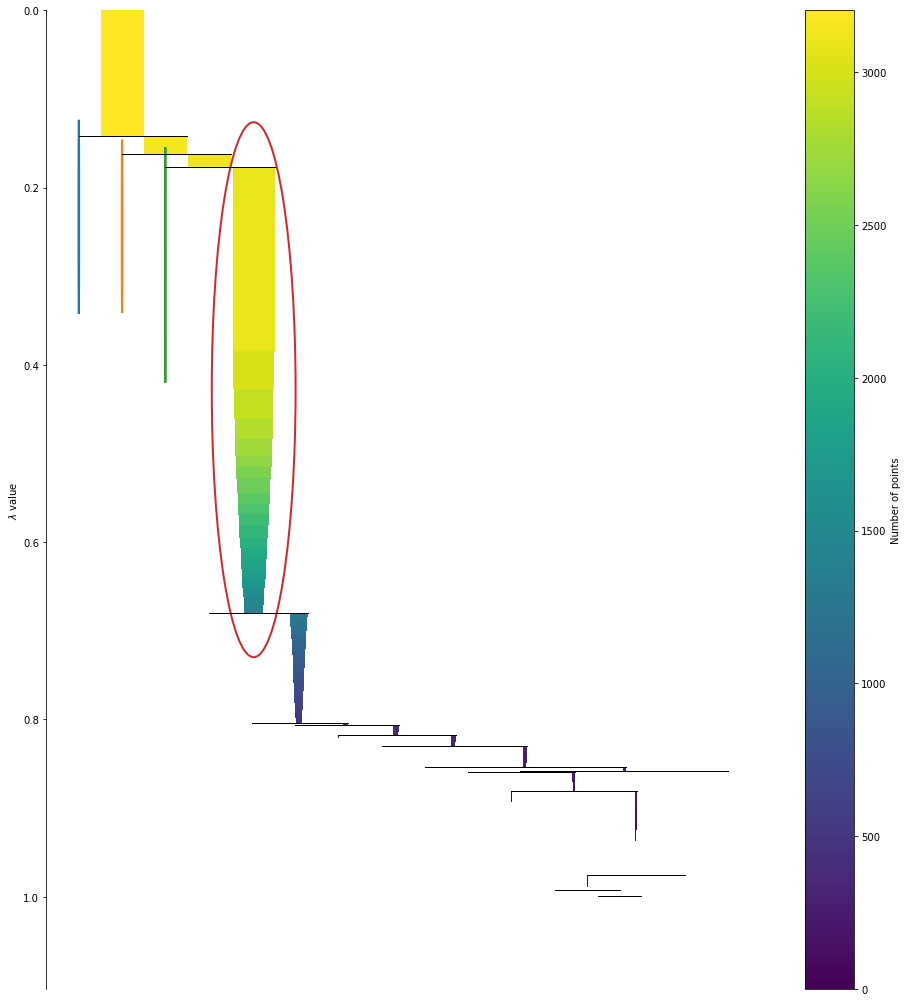

In [76]:
plt.figure(figsize = (16,18))
model1.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

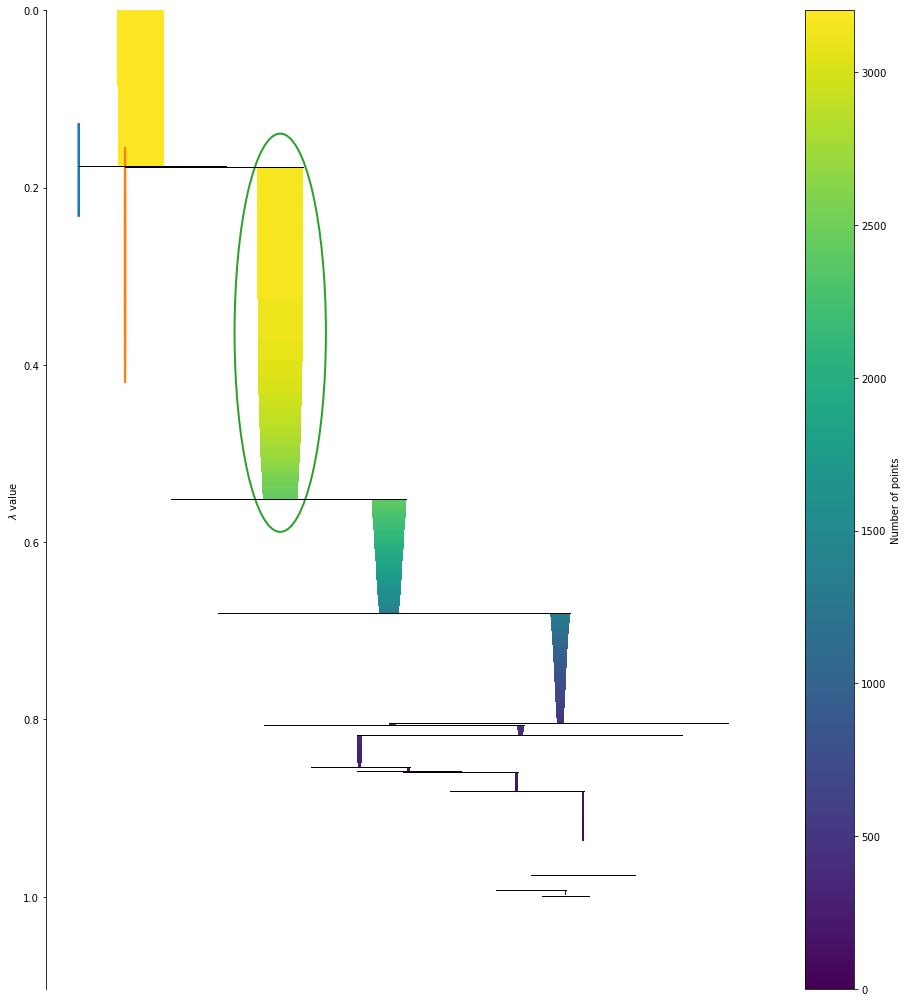

In [77]:
plt.figure(figsize = (16,18))
model2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

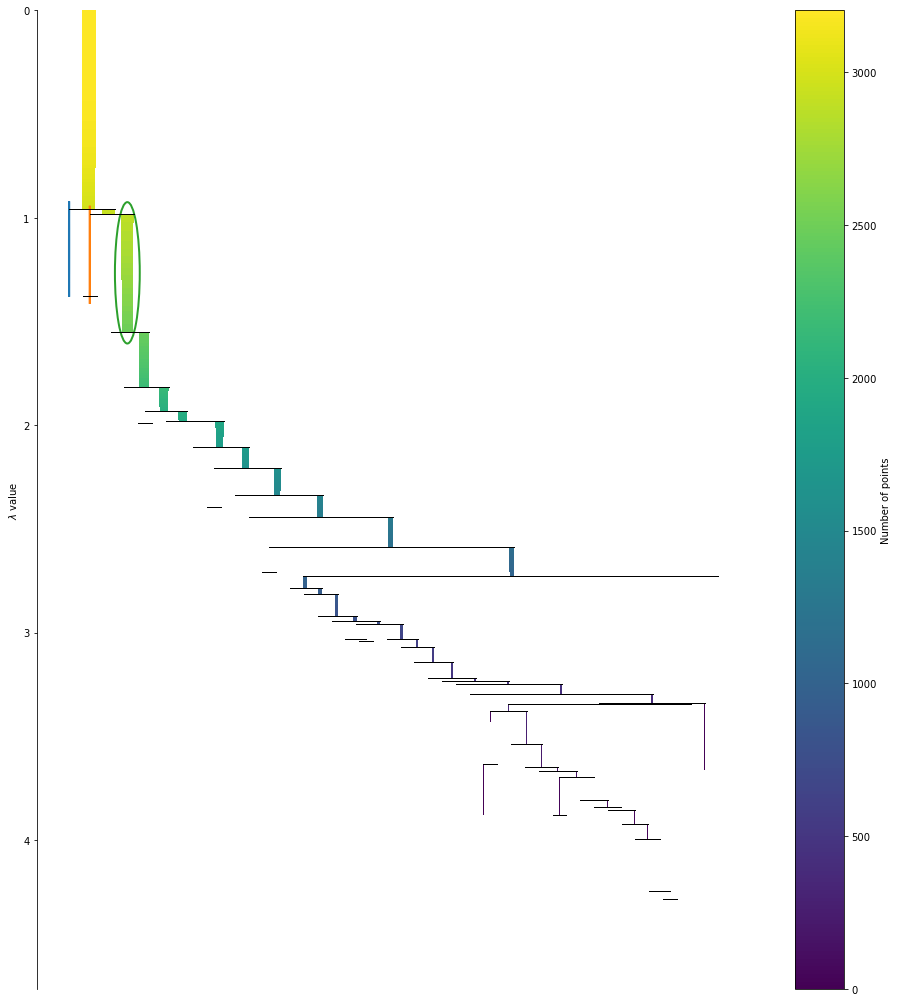

In [78]:
plt.figure(figsize = (16,18))
model3.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

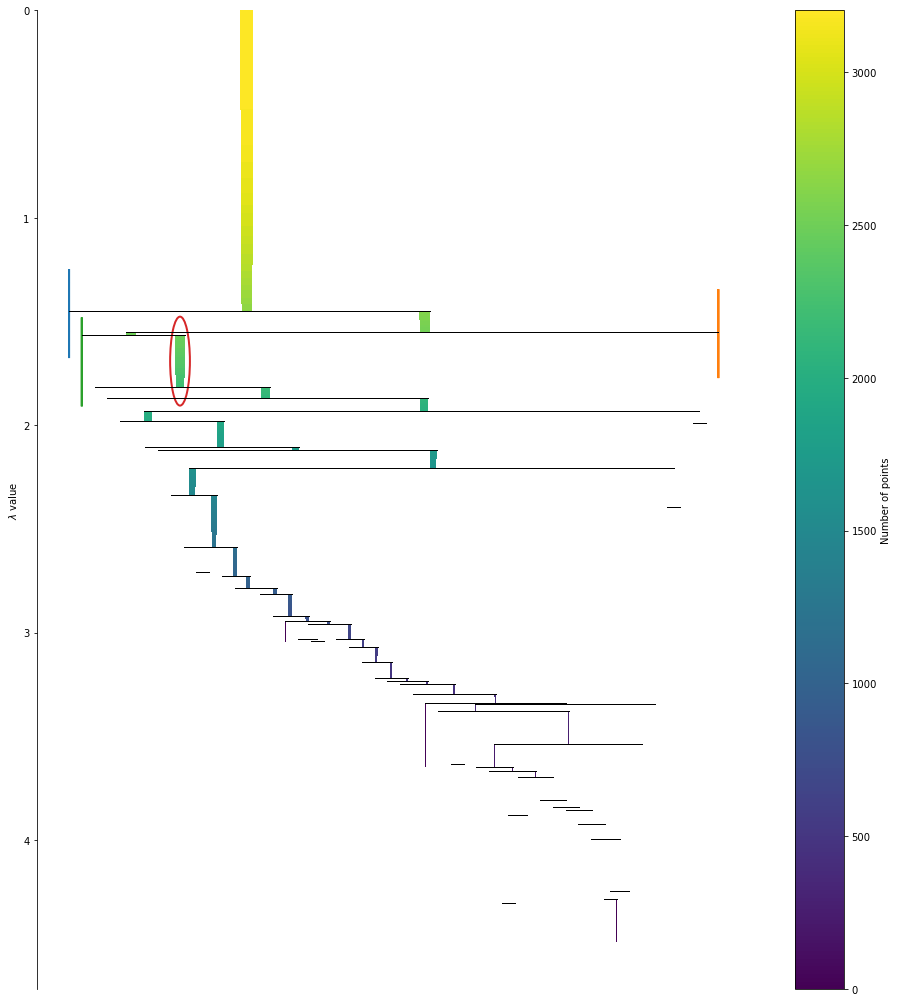

In [79]:
plt.figure(figsize = (16,18))
model4.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

# Clustering on UMAP Embedding

In [80]:
from denseclus import DenseClus

In [81]:
clf = DenseClus(umap_combine_method='intersection_union_mapper')

In [94]:
def preprocess_ep_UMAP(ep_plays):
    '''
    This function the ExtraPoint dataframe for clustering.

    Parameters:
    -----------
    ep_plays - ExtraPoint dataframe
    ...

    Returns:
    -----------
    ep_scale - processed ExtraPoint dataframe

    '''
    #reduce number of columns to those with numeric values or one-hot-encode the categoricals
    useful_cols = ['specialTeamsResult', 'yardlineNumber', 'gameClockSeconds', 
                   'penaltyCodes', 'penaltyYards', 'preSnapHomeScore', 
                   'preSnapVisitorScore', 'kicker_height', 'kicker_weight', #'expected_endzone_y', 
                   'endzone_y', 'endzone_y_error','endzone_y_off_center']
    
    columns = ep_plays.columns
    
    useful_cols.extend(col for col in columns if 'kicker_core_dist' in col)
    
    #useful_cols with blockers
    #useful_cols = ['specialTeamsResult', 'yardlineNumber', 'gameClockSeconds', 
                 #   'penaltyCodes', 'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 
                # 'kicker_height', 'kicker_weight', 'blocker_height', 'blocker_weight',
                # 'expected_endzone_y', 'endzone_y', 'kicker_core_dist']
                
    #need to drop nulls for clustering
    ep_df = ep_plays[useful_cols].dropna()
    #one-hot-encode SpecialTeamsResult and penaltyCodes
    #le_str = LabelEncoder()
    #le_pc = LabelEncoder()
    #ohe_str = le_str.fit_transform(ep_df['specialTeamsResult'])
    #ohe_pc = le_pc.fit_transform(ep_df['penaltyCodes'])
    new_eps = ep_df.drop(['specialTeamsResult', 'penaltyCodes'], axis=1)
    #new_eps['specialTeamsResult'] = ohe_str
    #new_eps['penaltyCodes'] = ohe_pc
    
    #scale data, but only non-categorical columns
    scale = StandardScaler()
    ep_scale = scale.fit_transform(new_eps)
    #TO-DO QUESTION: do we want to scale categoricals too? No
    
    #make this back into a data frame
    ep_scale = pd.DataFrame(ep_scale, columns = new_eps.columns)
    
    #add categorical columns back
    ep_scale['specialTeamsResult'] = ep_df['specialTeamsResult']
    ep_scale['penaltyCodes'] = ep_df['penaltyCodes']
    #we are running a distance dependent algorithm
    return ep_scale_UMAP, ep_df_UMAP

In [100]:
#just in case our data frame got messed up
ep_scale_UMAP, ep_df_UMAP = preprocess_ep_UMAP(extra_point_df)

In [85]:
clf.fit(ep_df_UMAP)

/Users/marcobertola/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [86]:
ep_df_UMAP['dc_cluster_id'] = clf.score()

In [87]:
clf.score().max()

1

In [88]:
clusterUMAP_0 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==0]
clusterUMAP_1 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==1]
#clusterUMAP_2 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==2]
#clusterUMAP_3 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==2]

outliersUMAP = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==-1]

In [89]:
print(clusterUMAP_0['specialTeamsResult'].value_counts())
print()
print(clusterUMAP_1['specialTeamsResult'].value_counts())
print()

print()
print(outliersUMAP['specialTeamsResult'].value_counts())

Kick Attempt Good    1351
Name: specialTeamsResult, dtype: int64

Kick Attempt Good    141
Name: specialTeamsResult, dtype: int64


Kick Attempt Good       1517
Kick Attempt No Good     188
Blocked Kick Attempt       6
Name: specialTeamsResult, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

In [99]:
clf_scale = DenseClus(umap_combine_method='intersection_union_mapper')

In [101]:
clf_scale.fit(ep_df_UMAP)

/Users/marcobertola/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [102]:
ep_df_UMAP['dc_cluster_id'] = clf_scale.score()

In [103]:
clf_scale.score().max()

2

In [104]:
clusterUMAP_0 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==0]
clusterUMAP_1 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==1]
clusterUMAP_2 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==2]
#clusterUMAP_3 = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==2]

outliersUMAP = ep_df_UMAP[ep_df_UMAP['dc_cluster_id']==-1]

In [105]:
print(clusterUMAP_0['specialTeamsResult'].value_counts())
print()
print(clusterUMAP_1['specialTeamsResult'].value_counts())
print()
print(clusterUMAP_2['specialTeamsResult'].value_counts())
print()

print()
print(outliersUMAP['specialTeamsResult'].value_counts())

Kick Attempt Good    1499
Name: specialTeamsResult, dtype: int64

Kick Attempt Good       1368
Kick Attempt No Good      10
Blocked Kick Attempt       3
Name: specialTeamsResult, dtype: int64

Kick Attempt No Good    99
Kick Attempt Good       10
Blocked Kick Attempt     3
Name: specialTeamsResult, dtype: int64


Kick Attempt Good       132
Kick Attempt No Good     79
Name: specialTeamsResult, dtype: int64


In [109]:
numerical_embedding = clf_scale.numerical_umap_.fit_transform(ep_scale)
categorical_embedding = clf_scale.categorical_umap_.fit_transform(ep_scale)

/Users/marcobertola/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


In [110]:
numerical_df = pd.DataFrame(numerical_embedding, columns=['x','y','z'])

In [111]:
numerical_df['cluster_id'] = clf_scale.score()

In [112]:
groups = numerical_df.groupby('cluster_id')

/Users/marcobertola/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


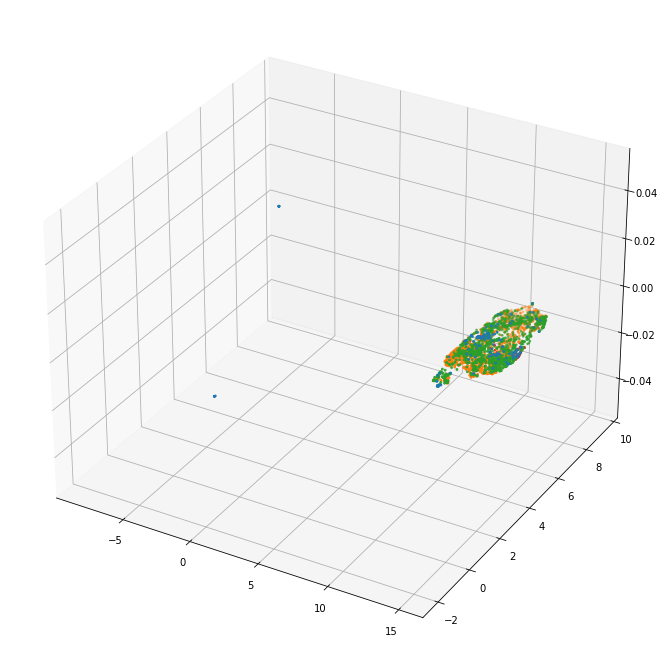

In [113]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')

for name, group in groups:
    plt.scatter(group.x, group.y, group.z, marker='.', label=name)

plt.savefig('umap_scale_embedding.png')